In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


776 SNe in original dataset.
Number of VDISP replaced with NaN: 176
579 SNe after paper-based quality cuts.
Features: ['LOGMSTAR', 'SFR', 'AGE', 'DN4000', 'VDISP', 'SDSS_g_minus_r']
Training rows: 579

=== Random Forest Performance ===
RMSE: 0.1918
MAE:  0.1432
R²:   0.0286


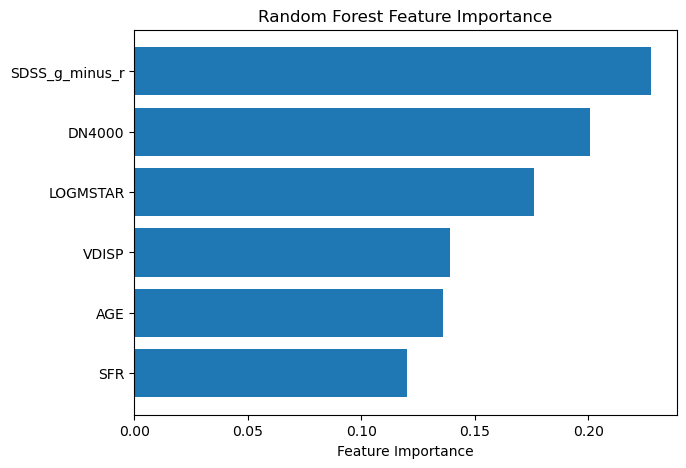

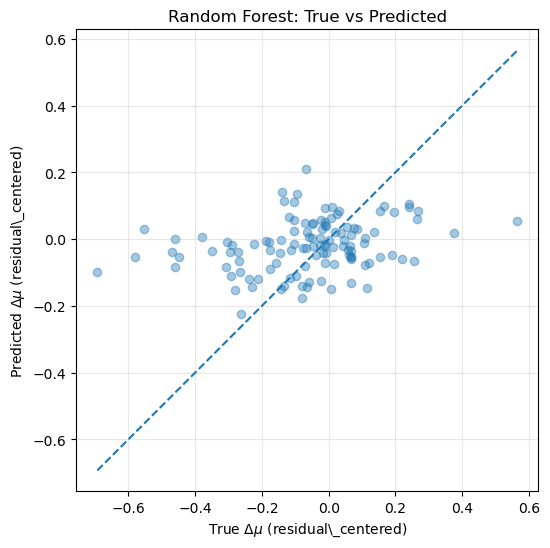

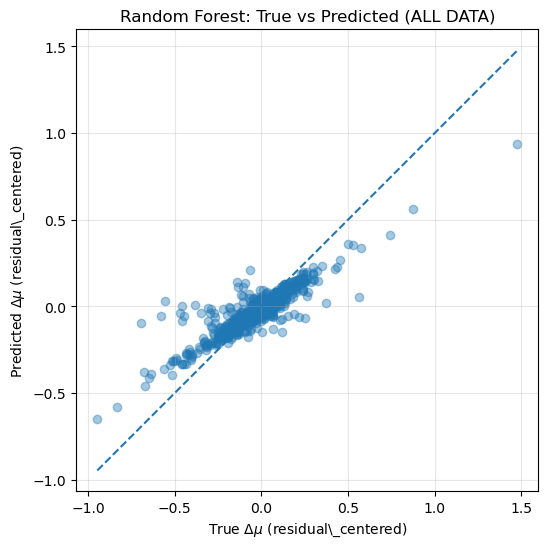

In [4]:

# ---------------------------------------------------------
# 1. Load CSV + apply light-curve cuts
# ---------------------------------------------------------
df = pd.read_csv("ZTF_snia_DESI_fastspec_hostprops_with_residuals.csv")

print(len(df), "SNe in original dataset.")

df = df[(df["lccoverage_flag"] == 1) & (df["fitquality_flag"] == 1)]

# Replace bad VDISP values with NaN
df.loc[df["VDISP"] == 125, "VDISP"] = np.nan
print("Number of VDISP replaced with NaN:", df["VDISP"].isna().sum())

print(len(df), "SNe after paper-based quality cuts.")

# ---------------------------------------------------------
# 2. Create g - r color
# ---------------------------------------------------------
df["SDSS_g_minus_r"] = df["ABSMAG01_SDSS_G"] - df["ABSMAG01_SDSS_R"]

# ---------------------------------------------------------
# 3. Feature list + target
# ---------------------------------------------------------
candidate_features = [
    "LOGMSTAR",
    "SFR",
    "AGE",
    "DN4000",
    "VDISP",
    "SDSS_g_minus_r",
]

target_column = "residual_centered"

X = df[candidate_features]
y = df[target_column]

print("Features:", candidate_features)
print("Training rows:", len(df))


# ---------------------------------------------------------
# 3. RANDOM FOREST REGRESSION PIPELINE
# ---------------------------------------------------------



# ------------------------------------
# Train/Test Split
# ------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------
# Build Pipeline
# ------------------------------------
# Imputation handles missing VDISP or other NaNs.
# StandardScaler is optional for RF but helps sometimes.
rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1,
    )),
])

# ------------------------------------
# Train Model
# ------------------------------------
rf_pipeline.fit(X_train, y_train)

# ------------------------------------
# Predictions
# ------------------------------------
y_pred = rf_pipeline.predict(X_test)

# ------------------------------------
# Metrics
# ------------------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n=== Random Forest Performance ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# ---------------------------------------------------------
# 4. Feature Importances
# ---------------------------------------------------------
rf_model = rf_pipeline.named_steps["rf"]
importances = rf_model.feature_importances_
feature_names = candidate_features

# Sort by importance
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(7,5))
plt.barh(np.array(feature_names)[idx], importances[idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()



import numpy as np
import matplotlib.pyplot as plt

# Make sure these are arrays
y_test_array = np.array(y_test)
y_pred_array = np.array(y_pred)

# 1:1 plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_array, y_pred_array, alpha=0.4)

# 1:1 line
min_val = min(y_test_array.min(), y_pred_array.min())
max_val = max(y_test_array.max(), y_pred_array.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.xlabel(r"True $\Delta \mu$ (residual\_centered)")
plt.ylabel(r"Predicted $\Delta \mu$ (residual\_centered)")
plt.title("Random Forest: True vs Predicted")
plt.gca().set_aspect("equal", "box")
plt.grid(alpha=0.3)
plt.show()



# Predictions on the full dataset
y_all_true = y.values
y_all_pred = rf_pipeline.predict(X)

plt.figure(figsize=(6, 6))
plt.scatter(y_all_true, y_all_pred, alpha=0.4)

min_val = min(y_all_true.min(), y_all_pred.min())
max_val = max(y_all_true.max(), y_all_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.xlabel(r"True $\Delta \mu$ (residual\_centered)")
plt.ylabel(r"Predicted $\Delta \mu$ (residual\_centered)")
plt.title("Random Forest: True vs Predicted (ALL DATA)")
plt.gca().set_aspect("equal", "box")
plt.grid(alpha=0.3)
plt.show()

Fold 1: RMSE=0.1917, NMAD=0.1501, R²=0.0298
Fold 2: RMSE=0.2029, NMAD=0.1496, R²=0.0019
Fold 3: RMSE=0.2598, NMAD=0.1852, R²=-0.0091
Fold 4: RMSE=0.1957, NMAD=0.1661, R²=0.0995
Fold 5: RMSE=0.1969, NMAD=0.1516, R²=-0.0949

[ZTF–DESI host ML, RF] 5-fold CV summary:
  RMSE (mean) = 0.2094 mag
  NMAD (mean) = 0.1605 mag
  R²   (mean) = 0.0054

OOF metrics (all data, but each point predicted out-of-fold):
  RMSE = 0.2109 mag
  MAE  = 0.1488 mag
  R²   = 0.0127


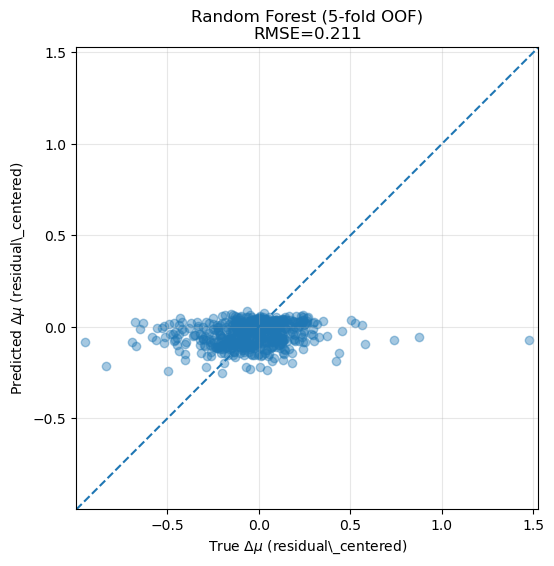

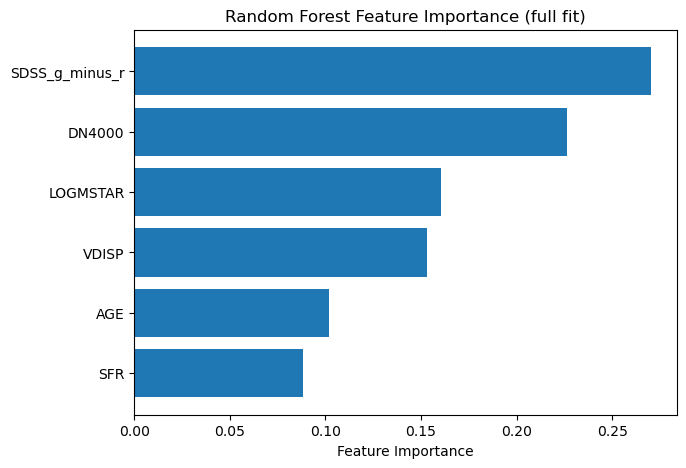

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------------------------------------------------
# 4. KFold cross-validation with Random Forest
# ---------------------------------------------------------

def nmad(a):
    med = np.median(a)
    return 1.4826 * np.median(np.abs(a - med))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmses, nmads, r2s = [], [], []
y_pred_oof = np.full_like(y.to_numpy(), np.nan, dtype=float)

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # pipeline for this fold
    rf_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("rf", RandomForestRegressor(
            n_estimators=500,
            max_depth=5,          # add some regularization so it doesn’t just memorize
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1,
        )),
    ])

    rf_pipeline.fit(X_train, y_train)
    y_val_pred = rf_pipeline.predict(X_val)
    y_pred_oof[val_idx] = y_val_pred

    resid = y_val_pred - y_val.to_numpy()
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    fold_nmad = nmad(resid)
    r2 = r2_score(y_val, y_val_pred)

    rmses.append(rmse)
    nmads.append(fold_nmad)
    r2s.append(r2)

    print(f"Fold {fold+1}: RMSE={rmse:.4f}, NMAD={fold_nmad:.4f}, R²={r2:.4f}")

print("\n[ZTF–DESI host ML, RF] 5-fold CV summary:")
print(f"  RMSE (mean) = {np.mean(rmses):.4f} mag")
print(f"  NMAD (mean) = {np.mean(nmads):.4f} mag")
print(f"  R²   (mean) = {np.mean(r2s):.4f}")

# ---------------------------------------------------------
# 5. OOF 1:1 plot (legit, no cheating)
# ---------------------------------------------------------
mask   = ~np.isnan(y_pred_oof)
y_true = y.to_numpy()[mask]
y_pred = y_pred_oof[mask]

rmse_oof = float(np.sqrt(((y_pred - y_true) ** 2).mean()))
mae_oof  = float(mean_absolute_error(y_true, y_pred))
r2_oof   = float(r2_score(y_true, y_pred))

print("\nOOF metrics (all data, but each point predicted out-of-fold):")
print(f"  RMSE = {rmse_oof:.4f} mag")
print(f"  MAE  = {mae_oof:.4f} mag")
print(f"  R²   = {r2_oof:.4f}")

lo = min(y_true.min(), y_pred.min()) - 0.05
hi = max(y_true.max(), y_pred.max()) + 0.05

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4)

plt.plot([lo, hi], [lo, hi], linestyle="--")
plt.xlim(lo, hi)
plt.ylim(lo, hi)

plt.xlabel(r"True $\Delta \mu$ (residual\_centered)")
plt.ylabel(r"Predicted $\Delta \mu$ (residual\_centered)")
plt.title(f"Random Forest (5-fold OOF)\nRMSE={rmse_oof:.3f}")
plt.gca().set_aspect("equal", "box")
plt.grid(alpha=0.3)
plt.show()

# ---------------------------------------------------------
# 6. Final model on full data + feature importance
# ---------------------------------------------------------
final_rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(
        n_estimators=500,
        max_depth=5,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
    )),
])

final_rf_pipeline.fit(X, y)

rf_model = final_rf_pipeline.named_steps["rf"]
importances = rf_model.feature_importances_
feature_names = candidate_features

idx = np.argsort(importances)[::-1]

plt.figure(figsize=(7, 5))
plt.barh(np.array(feature_names)[idx], importances[idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (full fit)")
plt.gca().invert_yaxis()
plt.show()